# Chapter 4. Classifying Surnames with a Multilayer Perceptron

## Imports

In [45]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [46]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>", mask_token="<MASK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {''@'':0, 'a':1, 'b':2, ....., 'Á': 76}
                                                  # _idx_to_token: {0:''@'', 1:'a', 2:'b', ....., 76:'Á'}
            
                                                  # _token_to_idx: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
                                                  # _idx_to_token: {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}
  
        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}
        self._mask_token = mask_token
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
            self.mask_index = self.add_token(self._mask_token)  # mask_index set to 0
               
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        token = token
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        token = token
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [47]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab           # _token_to_idx: {'@':0, 'a':1, 'b':2, ....., 'Á': 76}
        self.nationality_vocab = nationality_vocab     # _token_to_idx: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            surname (str): the surname

        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding 
        """
        #split the individual characters
        indices = [self.surname_vocab.lookup_token(char) for char in surname]
        if vector_length < 0:
            vector_length = len(indices)
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices     # e.g., "frankenstein , or the prometheus by mary wolls" -> [3, 5, 9, 3, .., 35]
        out_vector[len(indices):] = self.surname_vocab.mask_index # padding,                                                       # [3, 5, 9, 3, .., 35] -> [3, 5, 9, 3, .., 35, 0, 0, 0, 0]
        return out_vector
#         vocab = self.surname_vocab
#         one_hot = np.zeros(len(vocab), dtype=np.float32)  # in this dataset, vector size is 77.
#         for token in surname:
#             one_hot[vocab.lookup_token(token)] = 1        # e.g., kim -> [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ......, 0]
#         self.x = one_hot
#         return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)   # token is letter-level.
            nationality_vocab.add_token(row.nationality)
        
        return cls(surname_vocab, nationality_vocab)

### The Dataset

In [48]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        measure_len = lambda surname: len(surname)
        self._max_seq_length = max(map(measure_len, surname_df.surname))  
        
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights for handling unbalanced data
        class_counts = surname_df.nationality.value_counts().to_dict() # {'English': 2972, 'Russian': 2373, ....}
        
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0]) # e.g, index of English is 4
        sorted_counts = sorted(class_counts.items(), key=sort_key)   # sort by the index number of nationality_vocab
                                # {('Arabic', 1603), ('Chinese', 220), ('Czech', 414), ('Dutch', 236),('English', 2972), ...}

        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) 
                                                                     # [1/1603, 1/220, 1/414, 1/236, 1/2972, ...]
                                                                     # E.g., penalty for Chinese is higher than one for Arabic.
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)   # e.g., 'kim' -> [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ......, 0]

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)  # e.g., 'Korean' -> 11

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader: # {'x_surname': [[1,1,..,0,1], [0,0,...,1,0], ...], 
                                 #  'y_nationality': [4, 5, 10, ..., 14, 4]}
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_surname & y_nationality
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict  # return out_data_dict whenever this generator function is called

## The Model: SurnameClassifier

In [49]:
class SurnameClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim, embedding_size, padding_idx=0):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.embedding =  nn.Embedding(num_embeddings=input_dim,   
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        #hidden_dim = 25
        self.fc1 = nn.Linear(in_features=embedding_size,           # Applies a linear transformation to the incoming data
                             out_features=hidden_dim, bias = True)
        #self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features = output_dim, bias = True)
        #self.fc3 = nn.Linear(in_features=30, out_features = output_dim, bias = True)
        
        #self.bn1 = nn.BatchNorm1d(hidden_dim) # for batch norm, need to be defined for each layer
        #self.bn2 = nn.BatchNorm1d(hidden_dim)
        #self.bn3 = nn.BatchNorm1d(output_dim)
        #self.dpout = nn.Dropout(p=0.01) # for drop out, p = probability of an element to be zeroed. Default: 0.5


    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded =  self.embedding(x_in)
        x_embedded_sum = x_embedded.sum(dim=1)
        #x_embedded_sum = self.dpout(x_embedded_sum)
        x_in = x_embedded_sum
        intermediate_vector = self.fc1(x_in)                         # (batch, input_dim) -> (batch, hidden_dim)
        #intermediate_vector = self.bn1(intermediate_vector)          # batch norm
        m = nn.LeakyReLU(0.1)
        #intermediate_vector = self.dpout(intermediate_vector) 
        intermediate_vector = m(intermediate_vector)   
        #intermediate_vector = F.relu(intermediate_vector)            # activation function
        #intermediate_vector = self.bn2(intermediate_vector)          # batch norm
               # dropout
        
        prediction_vector = self.fc2(intermediate_vector)
        #intermediate_vector = self.bn3(intermediate_vector)          # batch norm
        #prediction_vector = self.fc3(intermediate_vector)            # (batch, hidden_dim) -> (batch, output_dim)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)  # (batch, output_dim)

        return prediction_vector                                     # (batch, output_dim)

## Training Routine

### Helper functions

In [50]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [51]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [52]:
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=1000,#300,
    embedding_size=200, #was 50
    # Training  hyper parameters
    seed=1337,
    num_epochs=25,#100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size= 2, #256,#was 64
    # Runtime options
    cuda=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)   
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch4/surname_mlp\model.pth
Using CUDA: False


### Initializations

In [53]:
# create dataset and vectorizer
print("Creating fresh!")
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab),
                               embedding_size=args.embedding_size)


Creating fresh!


In [54]:
for idx, m in enumerate(classifier.named_modules()):
        print(idx, '->', m)

0 -> ('', SurnameClassifier(
  (embedding): Embedding(80, 200, padding_idx=0)
  (fc1): Linear(in_features=200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=18, bias=True)
))
1 -> ('embedding', Embedding(80, 200, padding_idx=0))
2 -> ('fc1', Linear(in_features=200, out_features=1000, bias=True))
3 -> ('fc2', Linear(in_features=1000, out_features=18, bias=True))


In [55]:
for param in classifier.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([80, 200])
<class 'torch.nn.parameter.Parameter'> torch.Size([1000, 200])
<class 'torch.nn.parameter.Parameter'> torch.Size([1000])
<class 'torch.nn.parameter.Parameter'> torch.Size([18, 1000])
<class 'torch.nn.parameter.Parameter'> torch.Size([18])


In [56]:
vectorizer.surname_vocab._token_to_idx

{'@': 0,
 '<MASK>': 1,
 'G': 2,
 'a': 3,
 'b': 4,
 'e': 5,
 'r': 6,
 'S': 7,
 'y': 8,
 'g': 9,
 'h': 10,
 'K': 11,
 'o': 12,
 'u': 13,
 'i': 14,
 'I': 15,
 's': 16,
 'B': 17,
 't': 18,
 'T': 19,
 'n': 20,
 'H': 21,
 'd': 22,
 'A': 23,
 'l': 24,
 'm': 25,
 'M': 26,
 'f': 27,
 'Z': 28,
 'N': 29,
 'k': 30,
 'w': 31,
 'W': 32,
 'E': 33,
 'c': 34,
 'j': 35,
 'Q': 36,
 'D': 37,
 'z': 38,
 'F': 39,
 'C': 40,
 'R': 41,
 'Y': 42,
 'L': 43,
 'J': 44,
 'P': 45,
 'X': 46,
 ':': 47,
 'O': 48,
 '-': 49,
 'p': 50,
 'U': 51,
 'v': 52,
 'V': 53,
 '1': 54,
 'x': 55,
 '/': 56,
 'q': 57,
 'é': 58,
 'ê': 59,
 "'": 60,
 'É': 61,
 'ö': 62,
 'ä': 63,
 'ü': 64,
 'ß': 65,
 'ú': 66,
 'à': 67,
 'ò': 68,
 'è': 69,
 'ù': 70,
 'ó': 71,
 'ń': 72,
 'Ś': 73,
 'ą': 74,
 'á': 75,
 'Ż': 76,
 'ã': 77,
 'í': 78,
 'ñ': 79}

In [57]:
vectorizer.nationality_vocab._token_to_idx

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

### Training loop

In [58]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)  # add class_weight for an unbalanced dataset
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
#optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001) # weight_decay for L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10) # update learning rate

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])         # (batch, input_dim) -> (batch, output_dim)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])  # (batch, output_dim), (batch) -> scalar value
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 1
        val_bar.n = 1
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


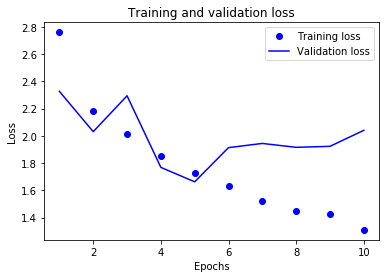

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

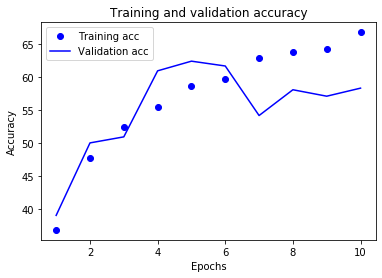

In [60]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [61]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'])) # load the best model

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_nationality_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].numpy())
    y_nationality_list.extend(batch_dict['y_nationality'].numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [62]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.6483283691177526;
Test Accuracy: 64.69879518072277


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_nationality_list, y_pred_list).T)  

[[224   1   2   3  12   1   1   0   2   5   3   0   0   0   6   0   1   0]
 [  0  17   1   0   4   0   2   0   0   0   0   6   0   0   4   1   1   2]
 [  0   0  12   2  26   0   5   0   0   0   2   0   4   1   5   1   0   0]
 [  0   0   3  13   7   0   3   0   0   0   0   1   0   0   5   0   1   0]
 [  0   7  17  11 306  13  32   7   8  11   2   2   1   1  22   8  10   4]
 [  0   0   1   1   1   5   0   0   0   1   0   0   0   0   3   0   0   0]
 [  0   0   3   0  13   1  26   0   0   1   0   0   1   0   4   0   2   0]
 [  0   0   1   0   0   0   0   9   0   1   0   0   0   0   0   0   0   0]
 [  4   0   0   1  10   1   1   0  13   3   2   0   0   1   2   2   0   0]
 [  3   3   3   3  40  10   6   1   3  49   4   0   2   2   6   0  11   2]
 [  8   2   5   0   3   2   4   3   1   2  99   1   1   0  10   0   1   0]
 [  0   3   0   0   0   0   0   0   0   0   2   3   0   0   0   0   0   1]
 [  0   0   1   0   0   0   0   0   0   1   0   0   4   0   0   0   0   0]
 [  0   0   1   0   5   0

In [64]:
nationality_classes = []
for i in range(len(dataset._vectorizer.nationality_vocab)):
    nationality_classes.append(dataset._vectorizer.nationality_vocab.lookup_index(i))
print(nationality_classes)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [65]:
import pandas as pd
cm = confusion_matrix(y_nationality_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=nationality_classes, columns=nationality_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True        Arabic  Chinese  Czech  Dutch  English  French  German  Greek  \
Predicted                                                                   
Arabic         224        1      2      3       12       1       1      0   
Chinese          0       17      1      0        4       0       2      0   
Czech            0        0     12      2       26       0       5      0   
Dutch            0        0      3     13        7       0       3      0   
English          0        7     17     11      306      13      32      7   
French           0        0      1      1        1       5       0      0   
German           0        0      3      0       13       1      26      0   
Greek            0        0      1      0        0       0       0      9   
Irish            4        0      0      1       10       1       1      0   
Italian          3        3      3      3       40      10       6      1   
Japanese         8        2      5      0        3       2       4      3   

In [66]:
print(classification_report(y_nationality_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       241
           1       0.45      0.52      0.48        33
           2       0.21      0.19      0.20        63
           3       0.39      0.36      0.38        36
           4       0.66      0.68      0.67       447
           5       0.42      0.14      0.21        35
           6       0.51      0.30      0.38        87
           7       0.82      0.38      0.51        24
           8       0.33      0.46      0.38        28
           9       0.33      0.54      0.41        90
          10       0.70      0.85      0.76       117
          11       0.33      0.23      0.27        13
          12       0.67      0.22      0.33        18
          13       0.04      0.11      0.06         9
          14       0.83      0.81      0.82       357
          15       0.00      0.00      0.00        12
          16       0.29      0.10      0.15        40
          17       0.00    

C:\Users\Gerald\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
